In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

## Pricing european call option

### Theoretical values

In [2]:
def price_european_call(S, K, T, r, sigma):
    """Calculate the price of a European call option using the Black-Scholes formula."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = (S * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2))
    return call_price

In [3]:
# Market parameters
N = 1_00_000 # Number of paths
T = 1 
S_0 = 100 # Initial stock price
sigma = 1 # Volatility
r = 0.1 # Risk-free rate

In [4]:
theoretical_value_80 = price_european_call(S=100, K=80, T=1, r=0.1, sigma=1)
theoretical_value_120 = price_european_call(S=100, K=120, T=1, r=0.1, sigma=1)

### Pure Monte Carlo estimation

In [5]:
def estimate_option_price_mc(N, T, r, S0, sigma, K, trajectory=False):
    Z = np.random.normal(0, 1, N)

    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

    payoff = np.exp(-r * T) * np.maximum(ST - K, 0)

    est_mc = np.cumsum(payoff) / np.arange(1, N + 1)

    if trajectory:
        return est_mc
    return est_mc[-1]

Payoff for K=80: 48.24890823371118
Payoff for K=120: 36.35959182036096


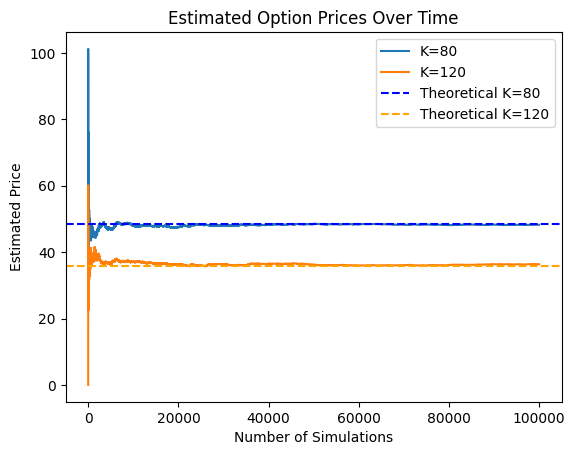

In [6]:
est_mc_80 = estimate_option_price_mc(N, T, r, S_0, sigma, 80, trajectory=True)
est_mc_120 = estimate_option_price_mc(N, T, r, S_0, sigma, 120, trajectory=True)

print(f"Payoff for K=80: {est_mc_80[-1]}")
print(f"Payoff for K=120: {est_mc_120[-1]}")

plt.plot(est_mc_80, label='K=80')
plt.plot(est_mc_120, label='K=120')
plt.axhline(y=theoretical_value_80, color='blue', linestyle='--', label='Theoretical K=80')
plt.axhline(y=theoretical_value_120, color='orange', linestyle='--', label='Theoretical K=120')
plt.xlabel('Number of Simulations')
plt.ylabel('Estimated Price')
plt.title('Estimated Option Prices Over Time')
plt.legend()
plt.show()

### Control variates

In [7]:
def estimate_option_price_cv(N, T, r, S0, sigma, K, trajectory=False):
    Z = np.random.normal(0, 1, N)

    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

    payoff = np.exp(-r * T) * np.maximum(ST - K, 0)

    est_mc = np.cumsum(payoff) / np.arange(1, N + 1)
    
    # control variate
    C = np.exp(-r * T) * ST

    cum_C = np.cumsum(C) / np.arange(1, N + 1)

    # expected value of the control variate
    E_C = S_0

    price = E_C + est_mc - cum_C

    if trajectory:
        return price
    return price[-1]

In [8]:
print(f"Control Variate Method Price for K=80: {estimate_option_price_cv(N, T, r, S_0, sigma, 80)}") 

Control Variate Method Price for K=80: 48.35129678197609


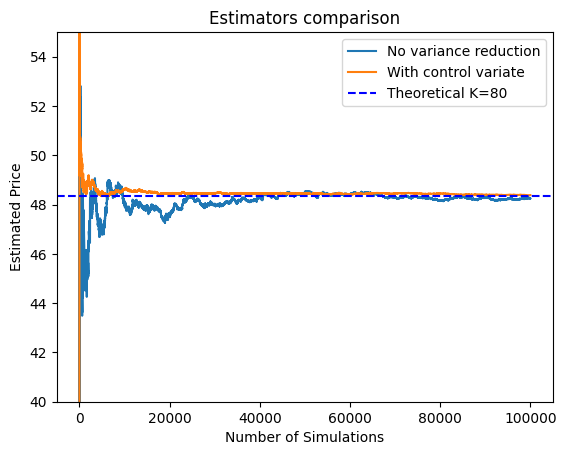

In [10]:
est_cv_80 = estimate_option_price_cv(N, T, r, S_0, sigma, 80, trajectory=True)
plt.plot(est_mc_80, label='No variance reduction')
plt.plot(est_cv_80, label='With control variate')
plt.xlabel('Number of Simulations')
plt.ylabel('Estimated Price')
plt.title('Estimators comparison')
plt.axhline(y=theoretical_value_80, color='blue', linestyle='--', label='Theoretical K=80')
plt.ylim(40, 55)
plt.legend()
plt.show()

### b) "turbo" control variates

In [11]:
def estimate_option_price_cv2(N, T, r, S0, sigma, K, trajectory=False):
    Z = np.random.normal(0, 1, N)

    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

    X = np.exp(-r * T) * np.maximum(ST - K, 0)
    Y = np.exp(-r * T) * ST

    # Kumulowane średnie X̄_n i Ȳ_n
    X_cumavg = np.cumsum(X) / np.arange(1, N + 1)
    Y_cumavg = np.cumsum(Y) / np.arange(1, N + 1)

    # Różnice od średnich (dla każdej n)
    X_diff = X - X_cumavg
    Y_diff = Y - Y_cumavg

    # Kumulowane sumy do liczenia b* (od n = 2, bo dla n=1 mamy 0/0)
    cum_cov = np.cumsum(X * Y) - np.cumsum(X) * Y_cumavg
    cum_var = np.cumsum(Y**2) - np.cumsum(Y) * Y_cumavg

    # Unikamy dzielenia przez 0 dla n = 1
    b_star = np.zeros(N)
    b_star[1:] = cum_cov[1:] / cum_var[1:]

    # Estymator turbo w wersji wektorowej:
    X_cv_turbo_vec = X_cumavg + b_star * (S_0 - Y_cumavg)

    if trajectory:
        return X_cv_turbo_vec
    return X_cv_turbo_vec[-1]

In [12]:
est_cv2_80 = estimate_option_price_cv2(N, T, r, S_0, sigma, 80, trajectory=True)
print(f"Control Variate Method Price (Turbo) for K=80: {est_cv2_80[-1]}")

Control Variate Method Price (Turbo) for K=80: 48.439271204792625


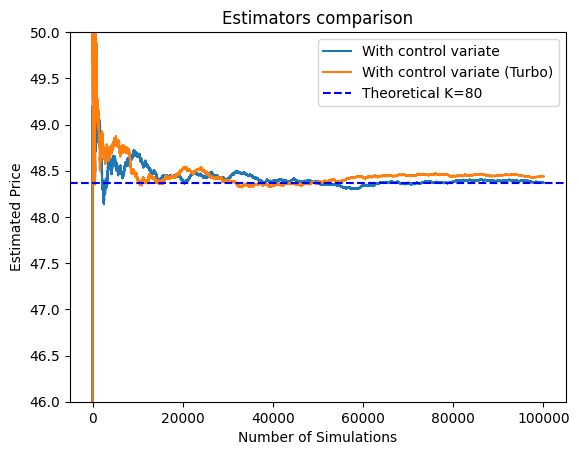

In [ ]:
est_cv_80 = estimate_option_price_cv2(N, T, r, S_0, sigma, 80, trajectory=True)
plt.plot(est_cv_80, label='With control variate')
plt.plot(est_cv2_80, label='With control variate (Turbo)')
plt.xlabel('Number of Simulations')
plt.ylabel('Estimated Price')
plt.title('Estimators comparison')
plt.axhline(y=theoretical_value_80, color='blue', linestyle='--', label='Theoretical K=80')
plt.ylim(46, 50)
plt.legend()
plt.show()

### zmienne antytetyczne 

In [17]:
def estimate_option_price_antithetic(N, T, r, S0, sigma, K, trajectory=False):
    Z = np.random.normal(0, 1, N)

    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

    ST_prim = S_0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * (-Z))

    price = np.exp(-r * T) * np.maximum(ST - K, 0)

    price_prim = np.exp(-r * T) * np.maximum(ST_prim - K, 0)

    est_antithetic = (np.cumsum(price_prim) + np.cumsum(price))/ (2 * np.arange(1, N + 1))
    
    if trajectory:
        return est_antithetic
    return est_antithetic[-1]

In [18]:
est_ant_80 = estimate_option_price_antithetic(N, T, r, S_0, sigma, 80, trajectory=True)
print(f"Antithetic Variates Price for K=80: {est_ant_80[-1]}")

Antithetic Variates Price for K=80: 48.33973463729618


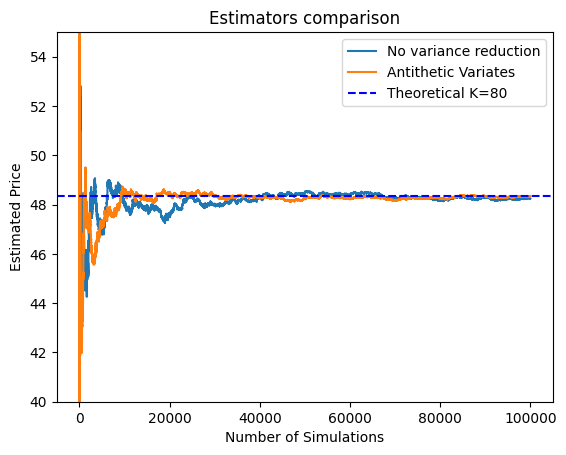

In [19]:
est_cv_80 = estimate_option_price_cv(N, T, r, S_0, sigma, 80, trajectory=True)
plt.plot(est_mc_80, label='No variance reduction')
# plt.plot(est_cv_80, label='With control variate')
# plt.plot(est_cv2_80, label='With control variate (Turbo)')
plt.plot(est_ant_80, label='Antithetic Variates')
plt.xlabel('Number of Simulations')
plt.ylabel('Estimated Price')
plt.title('Estimators comparison')
plt.axhline(y=theoretical_value_80, color='blue', linestyle='--', label='Theoretical K=80')
plt.ylim(40, 55)
plt.legend()
plt.show()

### d) metoda warstwowania

In [22]:
def estimate_option_price_stratified(N, T, r, S0, sigma, K, k=100, trajectory=False):
    n = N // k
    payoffs = []

    for i in range(k):
        # Losowe U w [i/k, (i+1)/k)
        U = np.random.uniform(low=i/k, high=(i+1)/k, size=n)
        
        # Przekształcenie U na standardowy rozkład normalny
        WT = np.sqrt(T) * stats.norm.ppf(U)
        
        # Symulacja S_T
        ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * WT)
        
        # Wypłata
        payoff = np.exp(-r * T) * np.maximum(ST - K, 0)
        payoffs.append(payoff)

    # Sklejamy wypłaty z wszystkich warstw
    all_payoffs = np.concatenate(payoffs)

    if trajectory:
        # Zwróć całą trajektorię estymatora MC
        return np.cumsum(all_payoffs) / np.arange(1, N + 1)
    else:
        # Tylko estymacja dla n = N
        return np.mean(all_payoffs)


In [23]:
est_ss_80 = estimate_option_price_stratified(N, T, r, S_0, sigma, 80, trajectory=True)
print(f"Stratified Sampling Price for K=80: {est_ss_80[-1]}")

Stratified Sampling Price for K=80: 48.486285317768576


### importance sampling

In [25]:
def estimate_option_price_importance_sampling(N, T, r, S0, sigma, K, mu, trajectory=False):
    Y = np.random.normal(mu, T, N)

    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * Y)

    payoff = np.exp(-r * T) * np.maximum(ST - K, 0)

    WT_dens = stats.norm.pdf(Y, 0, T)
    Y_dens = stats.norm.pdf(Y, mu, T)



    est_is = np.cumsum(payoff) / np.arange(1, N + 1) * (WT_dens / Y_dens)
    if trajectory:
        return est_is
    return est_is[-1]

In [26]:
est_is_80 = estimate_option_price_importance_sampling(N, T, r, S_0, sigma, 80, mu=0, trajectory=True)
print(f"Importance Sampling Price for K=80: {est_is_80[-1]}")

Importance Sampling Price for K=80: 48.70868678130215


#### Testing Importance Sampling with different mu values

In [27]:
mus = np.linspace(-2, 2, 5)
m = 1000
K = 80
estimates = np.zeros((len(mus), m))
for i, mu in enumerate(mus):
    for j in range(m):
        estimate = estimate_option_price_importance_sampling(N, T, r, S_0, sigma, K, mu)
        estimates[i, j] = estimate

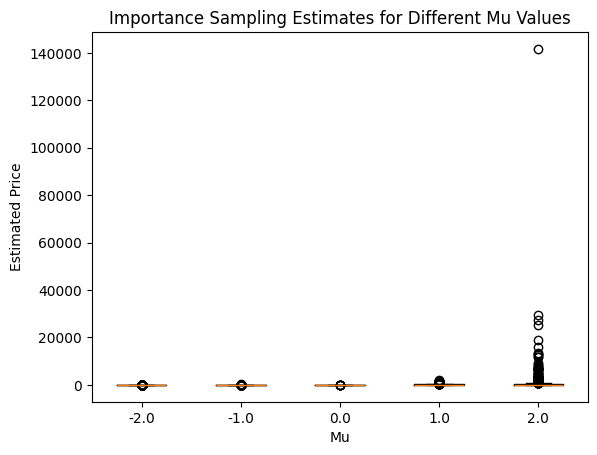

Mu = -2.00, Estimated Price: 0.5241228582195415, Theoretical Value: 48.3660, Variance: 4.9677
Mu = -1.00, Estimated Price: 7.368631355244543, Theoretical Value: 48.3660, Variance: 125.3064
Mu = 0.00, Estimated Price: 48.35785310890902, Theoretical Value: 48.3660, Variance: 0.1377
Mu = 1.00, Estimated Price: 197.7513496519657, Theoretical Value: 48.3660, Variance: 53834.2169
Mu = 2.00, Estimated Price: 755.3928404921443, Theoretical Value: 48.3660, Variance: 24626212.5273


In [28]:
plt.boxplot(estimates.T, positions=mus)
plt.xlabel('Mu')
plt.ylabel('Estimated Price')
plt.title('Importance Sampling Estimates for Different Mu Values')
plt.xticks()
plt.show()

for i, mu in enumerate(mus):
    print(f"Mu = {mu:.2f}, Estimated Price: {np.mean(estimates[i])}, Theoretical Value: {theoretical_value_80:.4f}, Variance: {np.var(estimates[i]):.4f}")

In [29]:
mus = np.linspace(-2, 2, 20)
estimates = []
for mu in mus:
    estimate = estimate_option_price_importance_sampling(N, T, r, S_0, sigma, K, mu, True)
    estimates.append(estimate[-1])

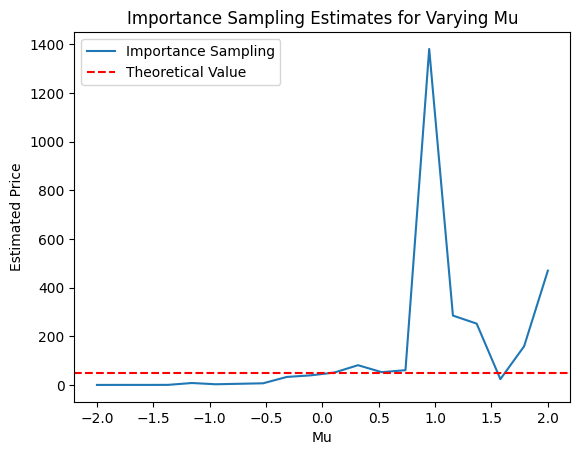

In [30]:
plt.plot(mus, estimates, label='Importance Sampling')
plt.axhline(theoretical_value_80, color='red', linestyle='--', label='Theoretical Value')
plt.xlabel('Mu')
plt.ylabel('Estimated Price')
plt.title('Importance Sampling Estimates for Varying Mu')
plt.legend()
plt.show()

## Price estimation methods comparison

In [ ]:
M = 1000
results = np.zeros((M, 6))

for i in range(M):
    print(f"Symulacja {i+1}/{M}:")

    mc = estimate_option_price_mc(N, T, r, S_0, sigma, 80)
    importance_sampling = estimate_option_price_importance_sampling(N, T, r, S_0, sigma, 80, 0)
    cv = estimate_option_price_cv(N, T, r, S_0, sigma, 80)
    cv2 = estimate_option_price_cv2(N, T, r, S_0, sigma, 80)
    antithetic = estimate_option_price_antithetic(N, T, r, S_0, sigma, 80)
    stratified = estimate_option_price_stratified(N, T, r, S_0, sigma, 80)

    results[i] = [mc, importance_sampling, cv, cv2, antithetic, stratified]

Symulacja 1/1000:
Symulacja 2/1000:
Symulacja 3/1000:
Symulacja 4/1000:
Symulacja 5/1000:
Symulacja 6/1000:
Symulacja 7/1000:
Symulacja 8/1000:
Symulacja 9/1000:
Symulacja 10/1000:
Symulacja 11/1000:
Symulacja 12/1000:
Symulacja 13/1000:
Symulacja 14/1000:
Symulacja 15/1000:
Symulacja 16/1000:
Symulacja 17/1000:
Symulacja 18/1000:
Symulacja 19/1000:
Symulacja 20/1000:
Symulacja 21/1000:
Symulacja 22/1000:
Symulacja 23/1000:
Symulacja 24/1000:
Symulacja 25/1000:
Symulacja 26/1000:
Symulacja 27/1000:
Symulacja 28/1000:
Symulacja 29/1000:
Symulacja 30/1000:
Symulacja 31/1000:
Symulacja 32/1000:
Symulacja 33/1000:
Symulacja 34/1000:
Symulacja 35/1000:
Symulacja 36/1000:
Symulacja 37/1000:
Symulacja 38/1000:
Symulacja 39/1000:
Symulacja 40/1000:
Symulacja 41/1000:
Symulacja 42/1000:
Symulacja 43/1000:
Symulacja 44/1000:
Symulacja 45/1000:
Symulacja 46/1000:
Symulacja 47/1000:
Symulacja 48/1000:
Symulacja 49/1000:
Symulacja 50/1000:
Symulacja 51/1000:
Symulacja 52/1000:
Symulacja 53/1000:
Sy

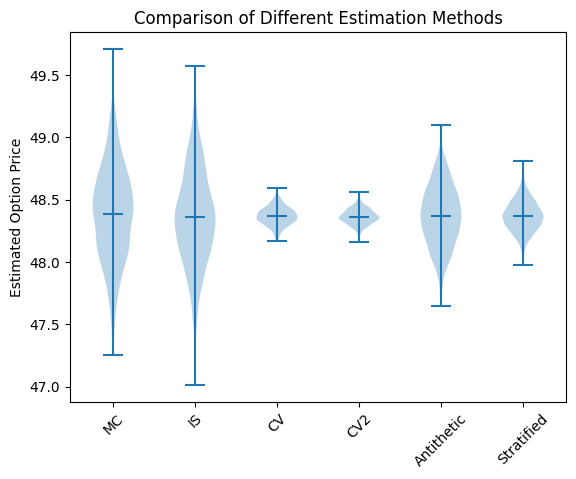

In [32]:
plt.violinplot(results, showmeans=True)
plt.xticks([1, 2, 3, 4, 5, 6], ['MC', 'IS', 'CV', 'CV2', 'Antithetic', 'Stratified'])
plt.xticks(rotation=45)
plt.ylabel('Estimated Option Price')
plt.title('Comparison of Different Estimation Methods')
plt.show()

Symulacja 1/5:
Symulacja 2/5:
Symulacja 3/5:
Symulacja 4/5:
Symulacja 5/5:


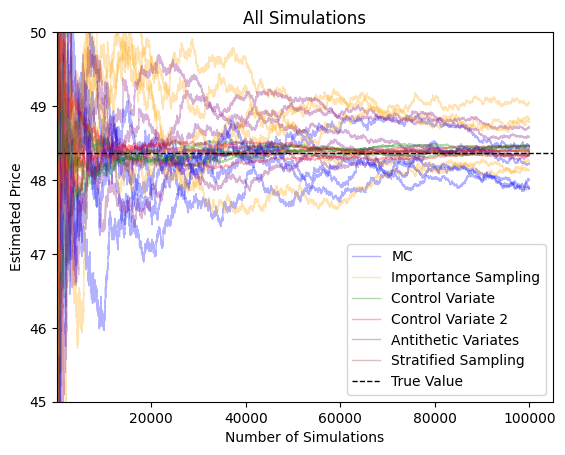

In [33]:
m = 5
added_labels = set()

for i in range(m):
    print(f"Symulacja {i+1}/{m}:")

    mc = estimate_option_price_mc(N, T, r, S_0, sigma, 80, trajectory=True)
    importance_sampling = estimate_option_price_importance_sampling(N, T, r, S_0, sigma, 80, 0, trajectory=True)
    cv = estimate_option_price_cv(N, T, r, S_0, sigma, 80, trajectory=True)
    cv2 = estimate_option_price_cv2(N, T, r, S_0, sigma, 80, trajectory=True)
    antithetic = estimate_option_price_antithetic(N, T, r, S_0, sigma, 80, trajectory=True)
    warstwowanie = estimate_option_price_stratified(N, T, r, S_0, sigma, 80)

    linewidth = 1
    alpha = 0.3

    def plot_once(label, data, color):
        lbl = label if label not in added_labels else None
        if lbl:
            added_labels.add(label)
        plt.plot(data, label=lbl, color=color, linewidth=linewidth, alpha=alpha)

    plot_once('MC', mc, 'blue')
    plot_once('Importance Sampling', importance_sampling, 'orange')
    plot_once('Control Variate', cv, 'green')
    plot_once('Control Variate 2', cv2, 'red')
    plot_once('Antithetic Variates', antithetic, 'purple')
    plot_once('Stratified Sampling', warstwowanie, 'brown')



plt.axhline(theoretical_value_80, color='black', linewidth=linewidth, linestyle='--', label="True Value")
plt.title('All Simulations')
plt.xlabel('Number of Simulations')
plt.ylabel('Estimated Price')
plt.xlim(left=10)
plt.ylim(45, 50)
plt.legend()
plt.show()

## Asian option pricing

In [34]:
def price_asian_option_mc(N, T, r, S_0, sigma, K, M):
    dt = T / M
    ti = np.linspace(dt, T, M)
    
    Z = np.random.randn(N, M)
    W = np.cumsum(np.sqrt(dt) * Z, axis=1)
    
    S = S_0 * np.exp((r - 0.5 * sigma**2) * ti + sigma * W) # ceny w różnych momentach

    arith_mean = S.mean(axis=1)
    price = np.exp(-r * T) * np.maximum(arith_mean - K, 0)

    return price.mean()

In [35]:
price_asian_option_mc(N, T, r, S_0, sigma, K, 50)

32.564660948167074

In [ ]:
def cena_opcji_geom(S0, K, r, sigma, T, M):
    dt = T / M
    
    ti = np.linspace(dt, T, M)
    T_bar = np.mean(ti)
    
    muG = np.log(S0) + (r - 0.5 * sigma**2) * T_bar
    varG = sigma**2 * np.sum(np.minimum.outer(ti, ti)) / M**2
    sigmaG = np.sqrt(varG)
    
    d1 = (muG - np.log(K) + varG) / sigmaG
    d2 = (muG - np.log(K)) / sigmaG

    price = np.exp(-r * T) * (np.exp(muG + 0.5 * varG) * stats.norm.cdf(d1) - K * stats.norm.cdf(d2))
    return price


def price_asian_option_cv(N, T, r, S_0, sigma, K, M):
    dt = T / M
    ti = np.linspace(dt, T, M)
    
    Z = np.random.randn(N, M)
    W = np.cumsum(np.sqrt(dt) * Z, axis=1)
    
    t_grid = np.linspace(dt, T, M)
    S = S_0 * np.exp((r - 0.5 * sigma**2) * t_grid + sigma * W)

    C_geo = cena_opcji_geom(S_0, K, r, sigma, T, M)
    geo_mean = np.prod(S, axis=1) ** (1 / M)

    arith_mean = S.mean(axis=1)


    X = np.exp(-r*T) * np.maximum(arith_mean - K, 0)
    Y = np.exp(-r*T) * np.maximum(geo_mean - K, 0)
    
    # b_opt = np.cov(X, Y)[0, 1] / np.var(Y)
    b = 1
    X_cv = X - b * (Y - C_geo)
    return X_cv.mean()


In [37]:
price_asian_option_cv(N, T, r, S_0, sigma, K, 50)

32.34514892753553

In [38]:
m = 100

results_asian = np.zeros((m, 2))
for i in range(m):
    print(f"Symulacja {i+1}/{m}:")

    mc = price_asian_option_mc(N, T, r, S_0, sigma, K, 50)
    cv = price_asian_option_cv(N, T, r, S_0, sigma, K, 50)
    results_asian[i] = [mc, cv]

Symulacja 1/100:
Symulacja 2/100:
Symulacja 3/100:
Symulacja 4/100:
Symulacja 5/100:
Symulacja 6/100:
Symulacja 7/100:
Symulacja 8/100:
Symulacja 9/100:
Symulacja 10/100:
Symulacja 11/100:
Symulacja 12/100:
Symulacja 13/100:
Symulacja 14/100:
Symulacja 15/100:
Symulacja 16/100:
Symulacja 17/100:
Symulacja 18/100:
Symulacja 19/100:
Symulacja 20/100:
Symulacja 21/100:
Symulacja 22/100:
Symulacja 23/100:
Symulacja 24/100:
Symulacja 25/100:
Symulacja 26/100:
Symulacja 27/100:
Symulacja 28/100:
Symulacja 29/100:
Symulacja 30/100:
Symulacja 31/100:
Symulacja 32/100:
Symulacja 33/100:
Symulacja 34/100:
Symulacja 35/100:
Symulacja 36/100:
Symulacja 37/100:
Symulacja 38/100:
Symulacja 39/100:
Symulacja 40/100:
Symulacja 41/100:
Symulacja 42/100:
Symulacja 43/100:
Symulacja 44/100:
Symulacja 45/100:
Symulacja 46/100:
Symulacja 47/100:
Symulacja 48/100:
Symulacja 49/100:
Symulacja 50/100:
Symulacja 51/100:
Symulacja 52/100:
Symulacja 53/100:
Symulacja 54/100:
Symulacja 55/100:
Symulacja 56/100:
S

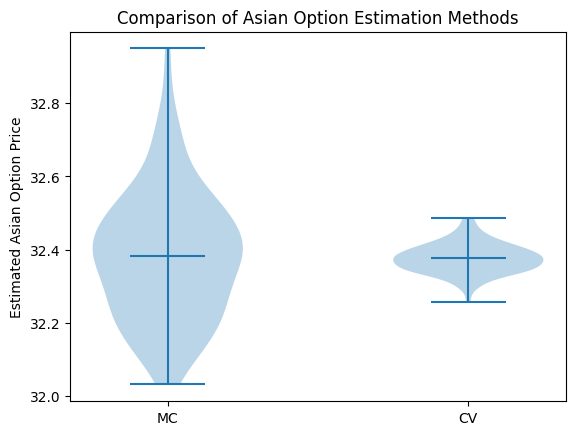

In [39]:
plt.violinplot(results_asian, showmeans=True)
plt.xticks([1, 2], ['MC', 'CV'])
plt.ylabel('Estimated Asian Option Price')
plt.title('Comparison of Asian Option Estimation Methods')
plt.show()

## c) Mix Monte Carlo method for:

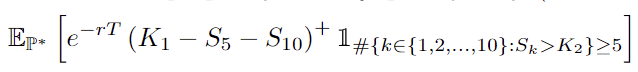

In [ ]:
def classic_monte_carlo(N, r, S0, sigma, K1, K2, T=10):
    ti = np.linspace(1, T, T)

    Z = np.random.randn(N, T)

    ST = S0 * np.exp((r - 0.5 * sigma**2) * ti + sigma * np.sqrt(ti) * np.cumsum(Z, axis=1))

    id = np.sum(ST > K2, axis=1) >= 5

    price = np.exp(-r*T) * np.maximum((K1 - ST[:, 4] - ST[:, 9]) * id, 0)
    
    return np.mean(price)

In [ ]:
def antithetic_monte_carlo(N, r, S0, sigma, K1, K2, T=10):
    ti = np.linspace(1, T, T)

    Z = np.random.randn(N, T)

    ST = S0 * np.exp((r - 0.5 * sigma**2) * ti + sigma * np.sqrt(ti) * np.cumsum(Z, axis=1))

    ST_prim = S0 * np.exp((r - 0.5 * sigma**2) * ti + sigma * np.sqrt(ti) * np.cumsum(-Z, axis=1))

    id = np.sum(ST > K2, axis=1) >= 5

    id_prim = np.sum(ST_prim > K2, axis=1) >= 5

    price = np.exp(-r*T) * np.maximum((K1 - ST[:, 4] - ST[:, 9]) * id, 0)
    price_prim = np.exp(-r*T) * np.maximum((K1 - ST_prim[:, 4] - ST_prim[:, 9]) * id_prim, 0)

    price = (np.cumsum(price) + np.cumsum(price_prim)) / (2 * np.arange(1, N + 1))
    
    return price

In [42]:
antithetic_monte_carlo(100000, 0.1, 100, 1, 200, 100)[-1]

0.7246144342730508

In [43]:
classic_monte_carlo(100000, 0.1, 100, 1, 200, 100)

0.7677990610539267

In [44]:
M = 1000
results_mc = np.zeros((M, 2))
for i in range(M):  
    print(f"Symulacja {i+1}/{M}:")

    mc = classic_monte_carlo(100000, 0.1, 100, 1, 200, 100)
    antithetic = antithetic_monte_carlo(100000, 0.1, 100, 1, 200, 100)[-1]
    results_mc[i] = [mc, antithetic]

Symulacja 1/1000:
Symulacja 2/1000:
Symulacja 3/1000:
Symulacja 4/1000:
Symulacja 5/1000:
Symulacja 6/1000:
Symulacja 7/1000:
Symulacja 8/1000:
Symulacja 9/1000:
Symulacja 10/1000:
Symulacja 11/1000:
Symulacja 12/1000:
Symulacja 13/1000:
Symulacja 14/1000:
Symulacja 15/1000:
Symulacja 16/1000:
Symulacja 17/1000:
Symulacja 18/1000:
Symulacja 19/1000:
Symulacja 20/1000:
Symulacja 21/1000:
Symulacja 22/1000:
Symulacja 23/1000:
Symulacja 24/1000:
Symulacja 25/1000:
Symulacja 26/1000:
Symulacja 27/1000:
Symulacja 28/1000:
Symulacja 29/1000:
Symulacja 30/1000:
Symulacja 31/1000:
Symulacja 32/1000:
Symulacja 33/1000:
Symulacja 34/1000:
Symulacja 35/1000:
Symulacja 36/1000:
Symulacja 37/1000:
Symulacja 38/1000:
Symulacja 39/1000:
Symulacja 40/1000:
Symulacja 41/1000:
Symulacja 42/1000:
Symulacja 43/1000:
Symulacja 44/1000:
Symulacja 45/1000:
Symulacja 46/1000:
Symulacja 47/1000:
Symulacja 48/1000:
Symulacja 49/1000:
Symulacja 50/1000:
Symulacja 51/1000:
Symulacja 52/1000:
Symulacja 53/1000:
Sy

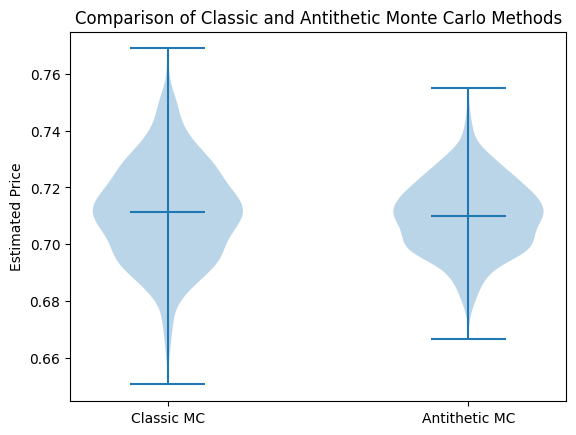

Classic MC Price: 0.7113597954471097, Antithetic MC Price: 0.7099015245204295


In [46]:
plt.violinplot(results_mc, showmeans=True)
plt.xticks([1, 2], ['Classic MC', 'Antithetic MC'])
plt.ylabel('Estimated Price')
plt.title('Comparison of Classic and Antithetic Monte Carlo Methods')
plt.show()
print(f"Classic MC Price: {np.mean(results_mc[:, 0])}, Antithetic MC Price: {np.mean(results_mc[:, 1])}")
